# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [13]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [65]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 1

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513017


In [66]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

## Auto-setup

In [67]:
# multilevel = hm.setup.auto_setup.setup(level.a, level.location, domain_size, max_levels=2, 
#                                        repetitive=True, symmetrize=True,
#                                       num_bootstrap_steps=1, caliber=4)

l 0 [96]
Coarsening level 0 -> 1 (96 points)
INFO     Kaczmarz
INFO     Relax conv 0.95 shrinkage 0.67 PODR RER 0.47 after 6 sweeps. Work 1.0 eff 0.67
WARNING  No handles with labels found to put in legend.
#smoothing steps on TVs 12
----------------------------------------
Bootstrap step 0
----------------------------------------
INFO     Generating 1 TVs with 12 sweeps
INFO     RER 0.295
INFO     Coarsening: aggregate_size 2 num_components 1
mock cycle rate [0.60317 0.28838 0.22139 0.23301 0.2033  0.1562  0.13287 0.13235 0.12389 0.11772 0.1146 ]
(96, 1) (48, 96)
2-level rate    [0.62859 0.28466 0.1722  0.16561 0.15349 0.13687 0.09654 0.06715 0.06419 0.05821 0.05395]
----------------------------------------
Bootstrap step 1
----------------------------------------
INFO     Relax cycle conv factor 0.597 asymptotic RQ -0.000 RER 0.000 P error 0.042
INFO     Improving vectors by relaxation cycles (6, 6; 12)
INFO     RER 0.074
INFO     Coarsening: aggregate_size 2 num_components 1
mock cy

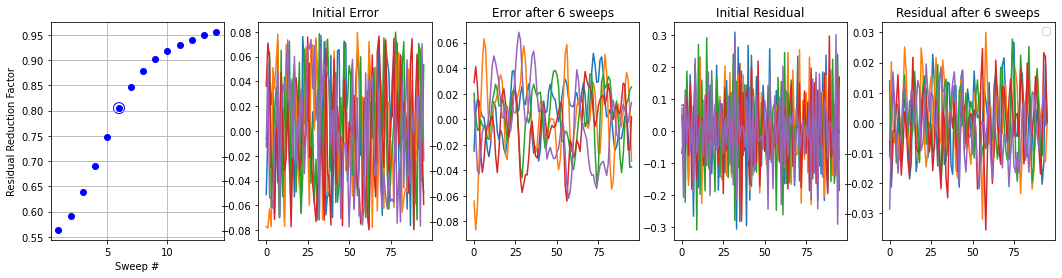

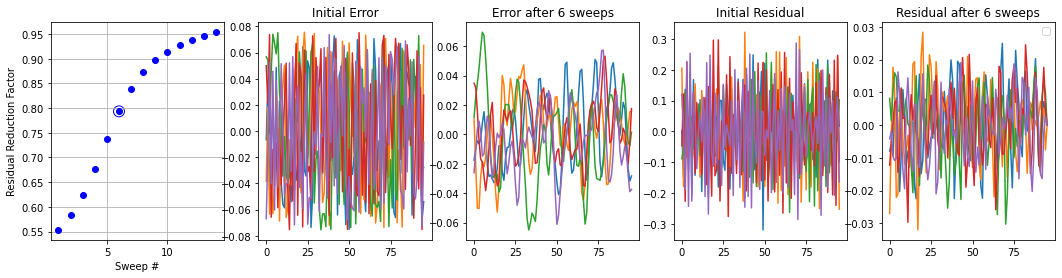

In [145]:
np.random.seed(11)
ml = hm.setup.hierarchy.multilevel.Multilevel.create(level)
aggregate_size = 2
num_components = 1
m = 4                    # Size of local domain for measuring mock cycle and two-levl rates [aggrgates].
caliber = 2              # Interpolation caliber.
num_bootstrap_steps = 3
num_levels = 2

for l in range(num_levels):
    print("l", l, [ml[i].size for i in range(len(ml))])
    fine_level = ml[l]
    print("=" * 80)
    print("Coarsening level {} -> {} ({} points)".format(l, l + 1, fine_level.size))
    print("=" * 80)
    # Check relaxation shrinkage & convergence.
    method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
        multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5,
        print_frequency=None)
    num_sweeps = method_info["relax"][1]
    nu = 2 * num_sweeps
    print("#smoothing steps on TVs", nu)

    ml_two_level = None
    for i in range(num_bootstrap_steps):
        print("-" * 40)
        print("Bootstrap step {}".format(i))
        print("-" * 40)
        # Create/improve TFs.
        if i == 0:
            x = helmholtz.analysis.stats.initial_tv(fine_level, nu, ideal_tv=ideal_tv, num_examples=num_examples)
        else:
            x = helmholtz.analysis.stats.improve_tv(x, ml_two_level, num_cycles=1, print_frequency=None,
                                                   nu_pre=6, nu_post=6, nu_coarsest=12)
        _LOGGER.info("RER {:.3f}".format(norm(fine_level.a.dot(x)) / norm(x)))

        # Update coarsening using current TFs.
        ml_two_level = helmholtz.analysis.stats.build_coarse_level(fine_level, x,
                               domain_size,
                               aggregate_size, num_components,
                               interpolation_method=interpolation_method,
                               caliber=caliber, 
                               fit_scheme=fit_scheme,
                               weighted=weighted,
                               neighborhood=neighborhood,
                               repetitive=repetitive,
                               m=m)
    ml.add(ml_two_level[1])

In [40]:
# # Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
# m = None
# nu_coarsest = -1
# hm.repetitive.locality.two_level_conv_factor(
#     ml, 8, num_levels=3,
#     nu_coarsest=200, print_frequency=1, debug=False, num_sweeps=10);

In [146]:
pd.DataFrame(ml[0].a.todense()[2, :5])


,0,1,2,3,4
0,-0.0833,1.3333,-2.2261,1.3333,-0.0833


In [147]:
pd.DataFrame(ml[1].a.todense()[2, :5])

,0,1,2,3,4
0,0.0436,0.2434,-0.1997,0.2434,0.0436


In [148]:
pd.DataFrame(ml[2].a.todense()[2, :5])

,0,1,2,3,4
0,0.0928,0.4060,0.4987,0.4060,0.0928


In [149]:
min(np.abs(np.real(eig(ml[0].a.todense())[0])))

5.187926986096482e-16

In [150]:
min(np.abs(np.real(eig(ml[1].a.todense())[0])))

1.0362754063524628e-05

In [151]:
min(np.abs(np.real(eig(ml[2].a.todense())[0])))

1.3865647426957647e-05

In [152]:
ml1 = ml.sub_hierarchy(1)
e, conv = hm.repetitive.locality.two_level_conv_factor(
    ml1, 5, num_levels=2,
    nu_coarsest=-1, print_frequency=1, debug=False, num_sweeps=10);

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      1.542e+00           0.394           3.917
INFO     1      3.770e-02  (0.024)  0.258  (0.656)  0.146
INFO     2      2.805e-03  (0.074)  0.248  (0.962)  0.011
INFO     3      2.731e-04  (0.097)  0.272  (1.094)  0.001
INFO     4      2.865e-05  (0.105)  0.239  (0.879)  0.000
INFO     5      2.380e-06  (0.083)  0.229  (0.958)  0.000
INFO     6      2.508e-07  (0.105)  0.294  (1.285)  0.000
INFO     7      2.609e-08  (0.104)  0.226  (0.769)  0.000
INFO     8      2.478e-09  (0.095)  0.277  (1.222)  0.000
INFO     9      2.712e-10  (0.109)  0.299  (1.081)  0.000
INFO     10     2.716e-11  (0.100)  0.206  (0.688)  0.000


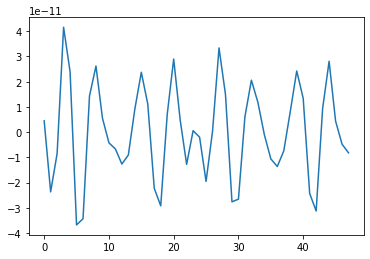

In [153]:
plt.plot(e)

In [154]:
norm(ml1[0].a @ e) / norm(e)

0.20564803514721633

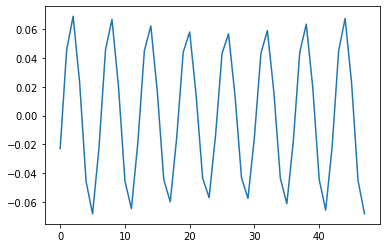

In [156]:
plt.plot(x)